<a href="https://colab.research.google.com/github/MC855FilmesParaTi/machinelearning/blob/FPTI-21/6_lfb_User_User_CF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
cd drive/Shareddrives/Filmes Pra TI - Machine Learning/Clone do Projeto - Luana/machinelearning

/content/drive/Shareddrives/Filmes Pra TI - Machine Learning/Clone do Projeto - Luana/machinelearning


# Loading dicts

In [5]:
import pickle
folder = 'data/processed/'

with open(folder +'IDS_DICT/user2movie_train.pickle', 'rb') as handle:
    user2movie = pickle.load(handle)

with open(folder +'IDS_DICT/movie2user_train.pickle', 'rb') as handle:
    movie2user = pickle.load(handle)

with open(folder +'IDS_DICT/usermovie2rating_train.pickle', 'rb') as handle:
    usermovie2rating = pickle.load(handle)

with open(folder +'IDS_DICT/usermovie2rating_val.pickle', 'rb') as handle:
    usermovie2rating_val = pickle.load(handle)

In [6]:
N = len(user2movie.keys())
N

10000

In [7]:
M = len(movie2user.keys())
M

2000

# Calculate User Similarities

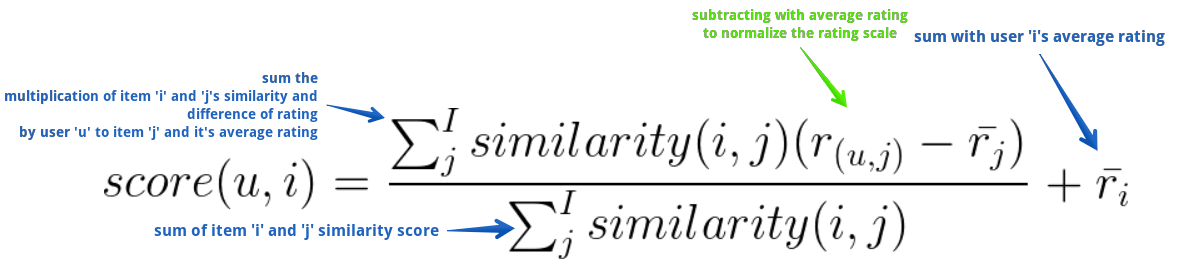

In [2]:
from IPython.display import Image
Image(filename='../reports/figures/user_colaborative_filtering.png') 

Os filtros colaborativos baseados em usuários utilizam k usuários vizinhos com gostos parecidos para realizar uma predição do score/avaliação para um usuário específico. Para reduzir o custo computacional, utilizamos dicionários para guardar a lista de usuários que avaliaram um filme x e também a lista de filmes que um usuário y avaliou. Além disso, guardamos também a avaliação de um usuário y para um filme x. 

A parte crítica desta formulação é calcular a matriz de similaridade entre todos usuários, que tem uma complexidade O(N²) em que N é o número de usuários. Isso porque, para cada usuário i, precisamos percorrer todos os outros usuários e calcular a similaridade de cosseno baseada nas avaliações dos filmes avaliados. Para reduzir a complexidade, guardamos apenas k = 25 vizinhos mais similares em um array e utilizamos apenas vizinhos com filmes pelo menos limit = 5 filmes em comum para computar a similaridade.

Logo, tendo essa matriz de similaridade, na qual contém os 25 vizinhos mais similares em relação ao gosto das avaliações passadas, podemos utilizar a fórmula na imagem acima para fazer a predição do score dos filmes não vistos por um usuário.

In [10]:
from sortedcontainers import SortedList
from tqdm.contrib.concurrent import thread_map

In [11]:
def compute_ratings(N, K = 25, limit = 5):

    neighbors = []
    avarages = []
    deviations = []

    def get_similarities(i):
        movies_i = user2movie[i]
        movies_i_set = set(movies_i)

        # calculate avg and deviation from the avg
        ratings_i = { movie:usermovie2rating[(i, movie)] for movie in movies_i}
        avg_i = np.mean(list(ratings_i.values()))
        dev_i = { movie: (rating - avg_i) for movie, rating in ratings_i.items()}
        dev_i_values = np.array(list(dev_i.values())) 
        sigma_i = np.sqrt([dev_i_values.dot(dev_i_values)]) # square of deviations
        
        avarages.append(avg_i)
        deviations.append(dev_i)

        top_k_neighbors = SortedList()
        for j in range(N):
            if j != i:
                movies_j = user2movie[j]
                movies_j_set = set(movies_j)
                common_movies = (movies_i_set & movies_j_set)
                if len(common_movies) > limit:
                    # calculate avg and deviation from the avg
                    ratings_j = { movie:usermovie2rating[(j, movie)] for movie in movies_j}
                    avg_j = np.mean(list(ratings_j.values()))
                    dev_j = { movie: (rating - avg_j) for movie, rating in ratings_j.items()}
                    dev_j_values = np.array(list(dev_j.values())) # square of deviations
                    sigma_j = np.sqrt([dev_j_values.dot(dev_j_values)]) # square of deviations

                    # correlation coefficient
                    numerator = sum(dev_j[m] * dev_i[m] for m in common_movies)
                    w_ij = numerator / (sigma_i * sigma_j)

                    # insert the weight to the sorted list and truncate to keep the K neighbors only
                    # negative weight, because list is sorted ascending
                    # max value (1) is closest
                    top_k_neighbors.add((-w_ij, j))
                    if len(top_k_neighbors) > K:
                        del top_k_neighbors[-1]

        neighbors.append(top_k_neighbors)
        # to retrieve neighbors of user i, just select neighbors[i]
    
    thread_map(get_similarities, range(N))

    return [avarages, deviations, neighbors]

In [12]:
def predict(i, m, avarages_i, deviations, neighbors_i):
    # calculates the weighted sum of deviations

    numerator = 0
    denominator = 0
    for neg_w, j in neighbors_i[i]:

        # the weight was stored as its negative
        try:
            numerator += -neg_w * deviations[j][m]
            denominator += abs(neg_w)
        except IndexError:
            # neighbor may not have rated the same movie
            # dont want to do dictionary lookup twice
            pass

    if denominator == 0:
        prediction = avarages_i
    else:
        prediction = numerator / denominator + avarages_i

    prediction = min(5, prediction)
    prediction = max(0.5, prediction)   
    return prediction

In [13]:
def mse(p, t):
    p = np.array(p)
    t = np.array(t)
    return np.mean((p - t) ** 2)

In [14]:
avarages, deviations, neighbors = compute_ratings(N)

  0%|          | 0/10000 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

Loop over dictionaries and predict the ratings for users and movies

In [ ]:
train_pred = []
train_true = []

for (i, m), true_rating in usermovie2rating.items():
    pred_rating = predict(i, m, avarages[i], deviations, neighbors[i])
    train_pred.append(pred_rating)
    train_true.append(true_rating)

In [ ]:
val_pred = []
val_true = []

for (i, m), true_rating in usermovie2rating_val.items():
    pred_rating = predict(i, m, avarages[i], deviations, neighbors[i])
    val_pred.append(pred_rating)
    val_true.append(true_rating)

In [ ]:
print('train mse: ', mse(train_pred, train_true))
print('validation mse: ', mse(val_pred, val_true))

# Outra Métrica

Tratar problema como uma classificação (like e dislike). Se o usuário avalidou o filme como 4.5 e a predição foi 4.8 significa que acertou, já que os dois são maiores que 2.5. Logo, colocar os ratings como classes {0, 1} e calcular a acurácia.

# Predição de scores/ratings de filmes não avaliados

In [ ]:
# pegar filmes que o usuario i nao assistir e chamar a função predict, adicionar isso em outro dicionário de predictions